In [3]:
import pandas as pd 

data = pd.read_csv('D:/Recommendation_final_music/dataset/dataset.csv')
print(len(data))
print(data.shape[1])

114000
21


In [4]:
data.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [5]:
data = data.drop(columns=['Unnamed: 0'])

##1.Preprocess missing value

In [7]:
data.isna().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [7]:
data = data.dropna()

In [8]:
data.isna().sum()

track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

##2.Check duplicate

In [9]:
before = len(data)
data = data.drop_duplicates(subset = ["track_id"])
after = len(data)
print(f"Removed {before - after} duplicate rows")

Removed 24259 duplicate rows


##3.Handle outliers

In [10]:
#outlier: duration_ms 
data = data[(data["duration_ms"] >= 30_000) & (data["duration_ms"] <= 15 * 60_000)]

#outlier: tempo
data = data[(data["tempo"] >= 50) & (data["tempo"] <= 200)]

#outlier: popularity
data = data[data["popularity"] > 0]

print(f"Remaining data size: {len(data)}")

Remaining data size: 79575


##4.Vectorization

In [12]:
from sentence_transformers import SentenceTransformer
import numpy as np 

data['artists_str'] = data["artists"].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else x
)

data["text_for_embedding"] = (
    data["track_name"] + " by " + data["artists_str"]
)

model = SentenceTransformer('Alibaba-NLP/gte-multilingual-base', trust_remote_code=True)

embeddings_semantic = model.encode(
    data["text_for_embedding"].tolist(),
    convert_to_numpy=True,
    show_progress_bar=True,
    batch_size = 64
)

print(f"Generated embeddings shape: {embeddings_semantic.shape}")
np.save('dataset/embeddings_semantic.npy', embeddings_semantic)



Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/1244 [00:00<?, ?it/s]

Generated embeddings shape: (79575, 768)


##numerical audio feature embedding(scaled vector)

In [13]:
from sklearn.preprocessing import MinMaxScaler

numerical_features = [
    "danceability", "energy", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "loudness"
]

scaler = MinMaxScaler()
embedding_numeric = scaler.fit_transform(data[numerical_features])

print(f"Numerical features embeddings shape: {embedding_numeric.shape}")
np.save('dataset/embeddings_numeric.npy', embedding_numeric)

Numerical features embeddings shape: (79575, 9)


In [34]:
embeddings_hybrid = np.hstack((embeddings_semantic, embedding_numeric))
print(f"Hybrid embeddings shape: {embeddings_hybrid.shape}")
np.save('dataset/embeddings_hybrid.npy', embeddings_hybrid)

Hybrid embeddings shape: (79575, 777)


##Visualization

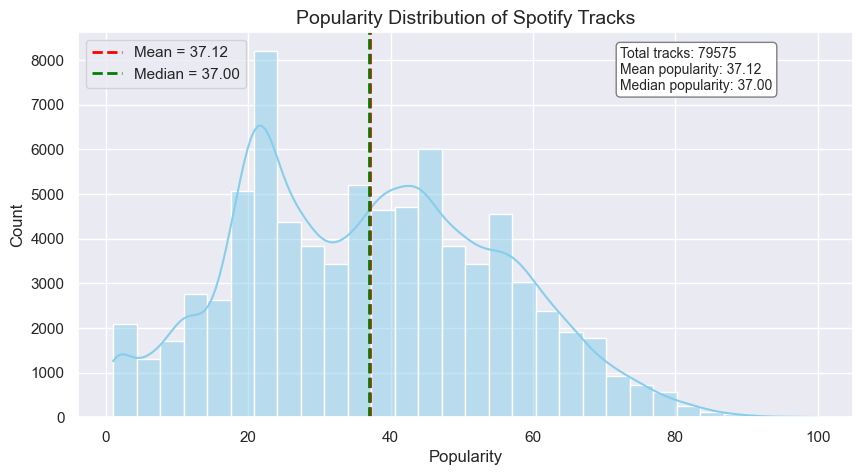

In [26]:
##1. Visualize popularity distribution of Spotify tracks
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))

ax = sns.histplot(data["popularity"], bins=30, kde=True, color="skyblue")

plt.title("Popularity Distribution of Spotify Tracks", fontsize=14)
plt.xlabel("Popularity")
plt.ylabel("Count")

mean_val = data["popularity"].mean()
median_val = data["popularity"].median()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")

plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f"Median = {median_val:.2f}")

plt.text(
    0.70, 0.85,
    f"Total tracks: {len(data)}\n"
    f"Mean popularity: {mean_val:.2f}\n"
    f"Median popularity: {median_val:.2f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1)
)

plt.legend()

plt.show()




C:\Users\Admin\AppData\Local\Temp\ipykernel_7404\1616569321.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


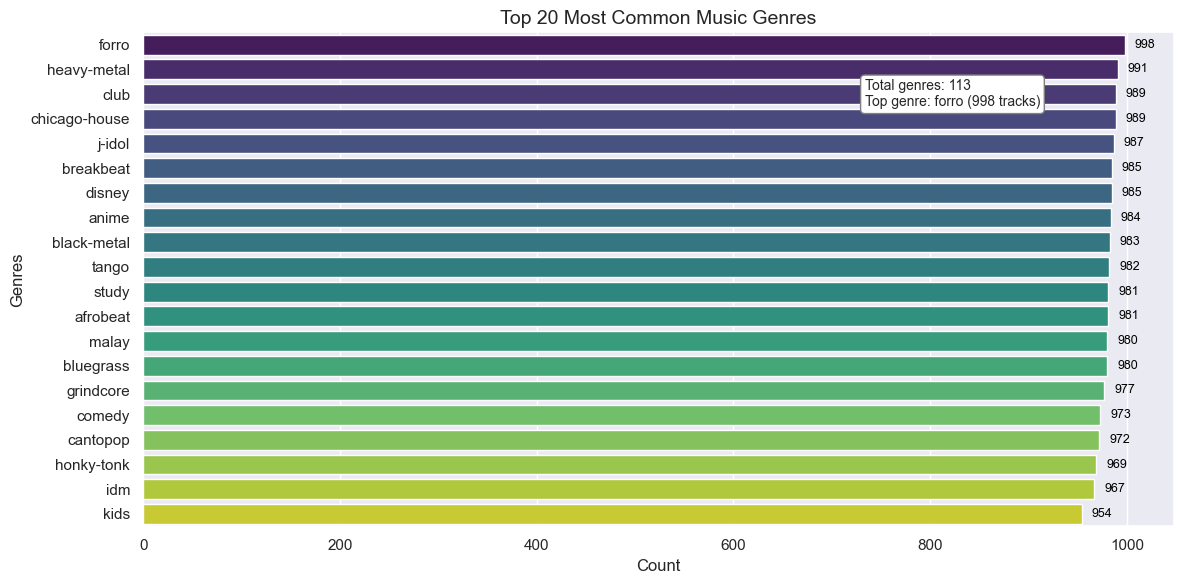

In [27]:
##2.Genre occurences(top 20)
plt.figure(figsize=(12,6))

genre_counts = data["track_genre"].value_counts().head(20)

ax = sns.barplot(
    x=genre_counts.values,
    y=genre_counts.index,
    palette="viridis"
)

plt.title("Top 20 Most Common Music Genres", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Genres")

total_genres = data["track_genre"].nunique()

plt.text(
    0.70, 0.85,
    f"Total genres: {total_genres}\n"
    f"Top genre: {genre_counts.index[0]} ({genre_counts.values[0]} tracks)",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray")
)

for i, v in enumerate(genre_counts.values):
    plt.text(v + 10, i, str(v), color="black", va="center", fontsize=9)

plt.tight_layout()
plt.show()



C:\Users\Admin\AppData\Local\Temp\ipykernel_7404\931897384.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


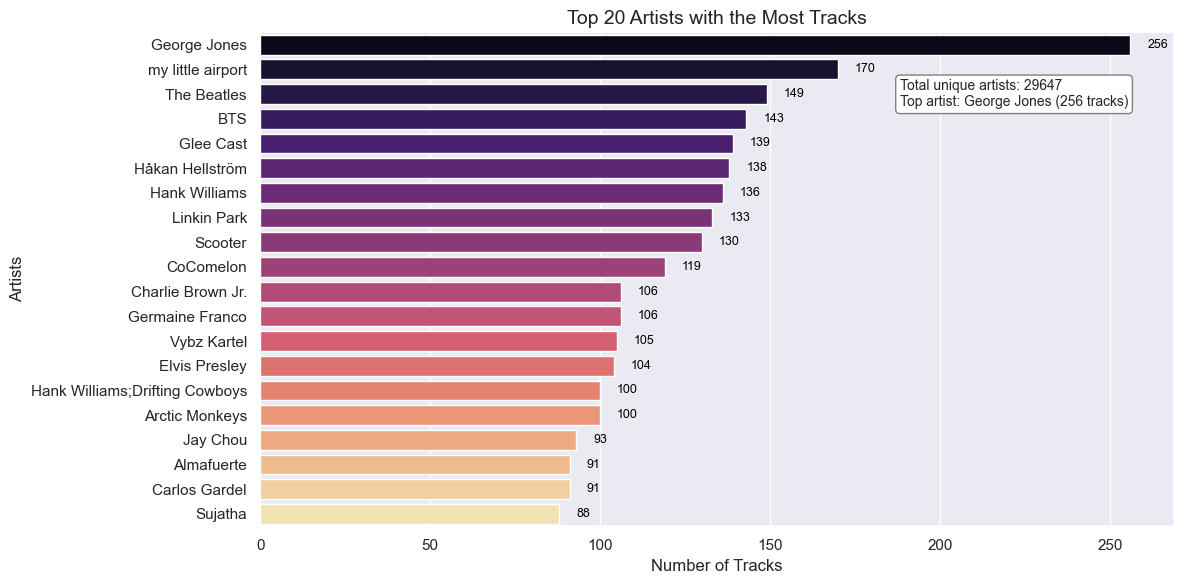

In [28]:
##3.Top 20 Artists with Most Tracks
plt.figure(figsize=(12,6))

artist_counts = data["artists_str"].value_counts().head(20)

ax = sns.barplot(
    x=artist_counts.values,
    y=artist_counts.index,
    palette="magma"
)

plt.title("Top 20 Artists with the Most Tracks", fontsize=14)
plt.xlabel("Number of Tracks")
plt.ylabel("Artists")

total_artists = data["artists_str"].nunique()

plt.text(
    0.70, 0.85,
    f"Total unique artists: {total_artists}\n"
    f"Top artist: {artist_counts.index[0]} ({artist_counts.values[0]} tracks)",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray")
)

for i, v in enumerate(artist_counts.values):
    plt.text(v + 5, i, str(v), color="black", va="center", fontsize=9)

plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_7404\122732486.py:48: UserWarning: Glyph 8599 (\N{NORTH EAST ARROW}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_7404\122732486.py:48: UserWarning: Glyph 8600 (\N{SOUTH EAST ARROW}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8599 (\N{NORTH EAST ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8600 (\N{SOUTH EAST ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


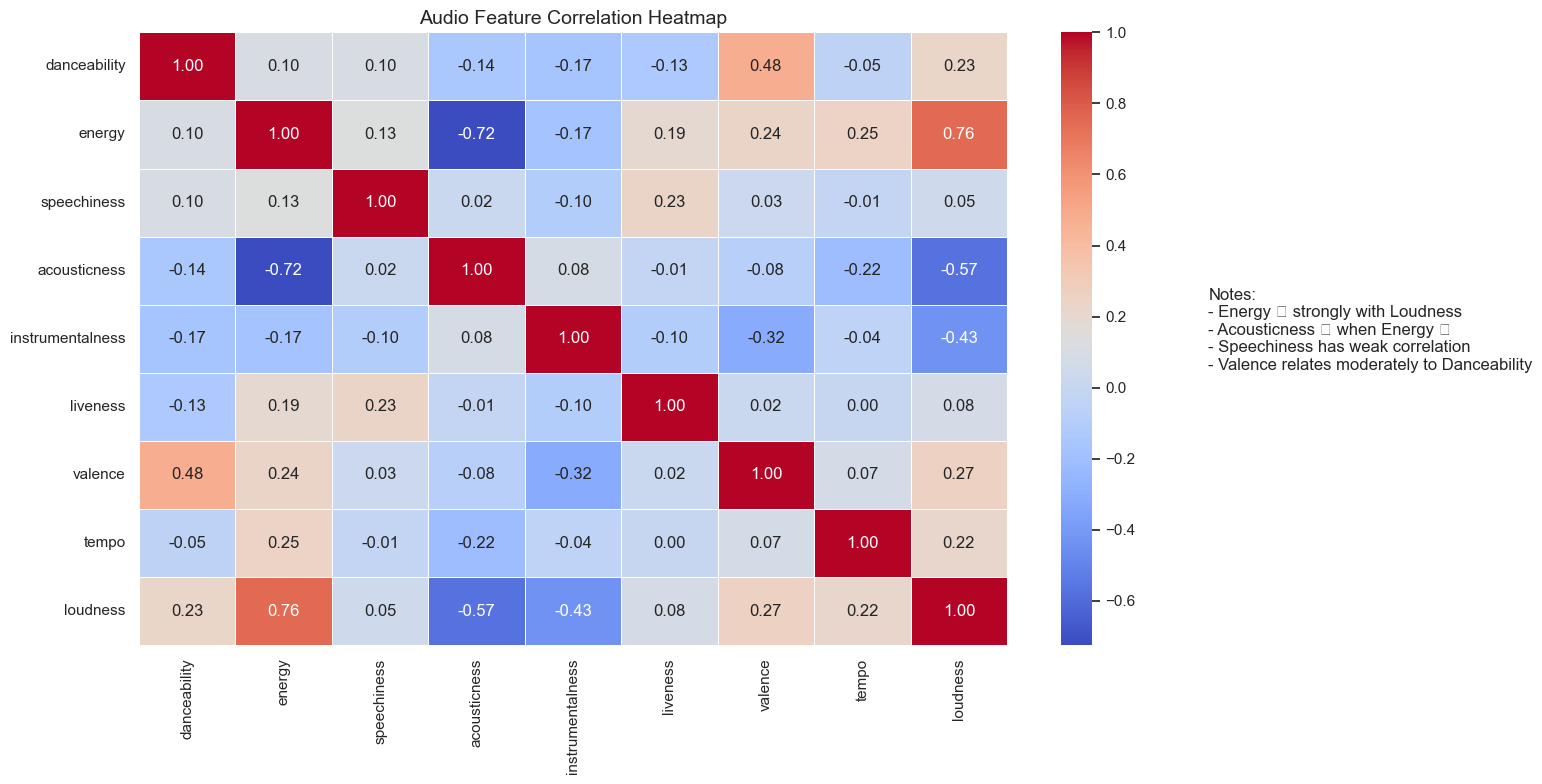

In [31]:
##4.Correlation Heatmap of Audio Features
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = [
    "danceability", "energy", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "loudness"
]

corr = data[numeric_features].corr()

fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(16, 8),
    gridspec_kw={"width_ratios": [4, 1]}
)

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=.5,
    cbar=True,
    ax=ax1
)

ax1.set_title("Audio Feature Correlation Heatmap", fontsize=14)

notes_text = (
    "Notes:\n"
    "- Energy ↗ strongly with Loudness\n"
    "- Acousticness ↘ when Energy ↗\n"
    "- Speechiness has weak correlation\n"
    "- Valence relates moderately to Danceability\n"
)

ax2.text(
    0.1, 0.5,
    notes_text,
    fontsize=12,
    va="center",
    wrap=True
)

ax2.axis("off")    

plt.tight_layout()
plt.show()


##4.Build model for recommendation system

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 

In [44]:
def find_track_index(track_name):
    matches = data[data["track_name"].str.lower() == track_name.lower()]
    if matches.empty:
        return None
    return matches.index[0]


In [50]:
def recommend_similar_tracks(track_name, top_k=10, embeddings=embeddings_hybrid):
    # tìm dòng có track_name
    matches = data[data["track_name"].str.lower() == track_name.lower()]
    if matches.empty:
        return "Can't not find the track!"

    # idx là label-index, ví dụ: 81959
    idx = matches.index[0]

    # CHUYỂN LABEL → POSITION (0..N-1)
    pos = data.index.get_loc(idx)

    # vector bài gốc
    query_vec = embeddings[pos].reshape(1, -1)

    # similarity
    sim_scores = cosine_similarity(query_vec, embeddings)[0]

    # top k
    top_indices = np.argsort(sim_scores)[::-1][1:top_k+1]

    # lấy dữ liệu bằng iloc
    result = data.iloc[top_indices][[
        "track_name", "artists_str", "track_genre"
    ]].copy()

    # thêm similarity
    result["similarity"] = sim_scores[top_indices]

    return result


In [55]:
recommend_similar_tracks("Wake me up", top_k=10, embeddings=embeddings_hybrid)


,track_name,artists_str,track_genre,similarity
17579,Wide Awake (Glee Cast Version),Glee Cast,club,0.926789
4181,Make You Feel My Love,Sleeping At Last,ambient,0.921512
11684,From The Morning,Nick Drake,british,0.921014
15537,Up All Night,Rewind;Julia Alexa,chill,0.920203
265,Dance Monkey,Roses & Frey,acoustic,0.918478
62644,Turn Me On,Norah Jones,j-pop,0.918366
962,With or Without You,Roses & Frey,acoustic,0.917646
103007,All of Me,John Legend,soul,0.917514
369,Dusk Till Dawn - Acoustic,Blame Jones,acoustic,0.917059
11733,Wake Up Alone,Amy Winehouse,british,0.916172


#5.Evaluate model

In [56]:
def get_true_genre(track_name):
    idx = find_track_index(track_name)
    if idx is None:
        return None 
    return data.loc[idx, "track_genre"]

In [53]:
def evaluate_model(track_name,top_k = 10):
    true_genre = get_true_genre(track_name)
    if true_genre is None:
        return None 
    result = recommend_similar_tracks(track_name,top_k = top_k)
    
    retrieved = len(result)
    relevant = sum(result["track_genre"] == true_genre)

    precision = relevant / retrieved 
    total_item_same_genres = sum(data["track_genre"] == true_genre)
    recall = relevant / total_item_same_genres

    return precision, recall

In [57]:
import random

test_tracks = random.sample(list(data["track_name"].unique()), 100)

precisions = []
recalls = []

for track in test_tracks:
    p, r = evaluate_model(track, top_k=10)
    precisions.append(p)
    recalls.append(r)

print("Precision:", sum(precisions)/len(precisions))
print("Recall:", sum(recalls)/len(recalls))


Precision: 0.325
Recall: 0.003884318889116832


In [58]:
data = data.reset_index(drop=True)
data.to_csv('dataset/dataset_cleaned.csv', index=False)